# Is Shohei Ohtani Swinging More Strikes on Low Pitches This Season? 
A batting analysis for Shohei Ohtani 

### *Data*
- We use the [pybaseball](https://github.com/jldbc/pybaseball) package to acquire baseball data.
### *Packages*
- Polars, plotnine, and pybaseball. 
### *References*
- Refer to [this statcast website](https://baseballsavant.mlb.com/csv-docs) for details of the definition of each column.
### *Context and Description of the viz*
- This analysis is for me to look at the data to confirm my assumption/observations that Ohtani is getting fewer swinging strikes on low pitches this 2024 season. And that might be one of the reasons why Ohtani is hitting much better than the last few seasons. 
- We create scatter plots showing pitches thrown to Ohtani, categorized by pitch locations and whether he swung or not.  

## 0. Import packages

In [20]:
import polars as pl
from pybaseball import statcast_batter
from pybaseball import playerid_lookup
from datetime import datetime

## 1. Getting player's info and batting stats

In [21]:
CURRENT_YEAR = datetime.today().year

player = playerid_lookup(first='Shohei', last='Ohtani')
player_batting_stats = pl.from_pandas(statcast_batter('2022-01-01', '2024-12-31', player_id=player.key_mlbam[0]))

Gathering Player Data


Taking a peek at what's read into dataframes

In [22]:
player_batting_stats.head(), player_batting_stats.select('description').unique()

(shape: (5, 112)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ pitch_typ ┆ game_date ┆ release_s ┆ release_p ┆ … ┆ pitcher_d ┆ batter_da ┆ pitcher_d ┆ batter_d │
 │ e         ┆ ---       ┆ peed      ┆ os_x      ┆   ┆ ays_since ┆ ys_since_ ┆ ays_until ┆ ays_unti │
 │ ---       ┆ str       ┆ ---       ┆ ---       ┆   ┆ _prev_gam ┆ prev_game ┆ _next_gam ┆ l_next_g │
 │ str       ┆           ┆ f64       ┆ f64       ┆   ┆ e         ┆ ---       ┆ e         ┆ ame      │
 │           ┆           ┆           ┆           ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
 │           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ FF        ┆ 2024-07-0 ┆ 96.3      ┆ -1.94     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
 │           ┆ 9         ┆           ┆           ┆   ┆           

## 2. Transforming data

- Adding columns to label pitch locations
- Filter data to only include regular season stats
- Selecting columns necessary for plotting
- Filter data to only include the number of games played in the current season

In [23]:
lower_limit_strike_zone = 1.5

df = (
    player_batting_stats
    .with_columns(
        pl.col('game_date').cast(pl.Date),
        pl.when(pl.col('description')=='swinging_strike').then(pl.lit('swinging_strike'))
        .when(pl.col('description')=='swinging_strike_blocked').then(pl.lit('swinging_strike'))
        .otherwise(pl.lit('other'))
        .alias('swinging_strike_flg'),
        pl.when(
            pl.col('description')=='swinging_strike',
            pl.col('plate_z')<lower_limit_strike_zone
        ).then(pl.lit('swinging_strike_low'))
        .when(pl.col('plate_z')<lower_limit_strike_zone).then(pl.lit('low_pitch'))
        .when(pl.col('description')=='swinging_strike').then(pl.lit('swinging_strike'))
        .when(pl.col('description')=='swinging_strike_blocked').then(pl.lit('swinging_strike'))
        .otherwise(pl.lit('other'))
        .alias('swinging_strike_detail_flg'),
    )
    .filter(pl.col('game_type')=='R')
    .select(
        'game_year',
        'game_date',
        'description',
        'swinging_strike_flg',
        'swinging_strike_detail_flg',
        'plate_x',
        'plate_z',
        pl.col('game_date').rank(method='dense').over('game_year').alias('game_number_in_season')
    )
    .filter(
        pl.col('game_number_in_season')<=pl.col('game_number_in_season').filter(pl.col('game_year')==CURRENT_YEAR).max()
    )
    .sort('swinging_strike_flg')
)

df.head()

game_year,game_date,description,swinging_strike_flg,swinging_strike_detail_flg,plate_x,plate_z,game_number_in_season
i64,date,str,str,str,f64,f64,u32
2024,2024-07-09,"""ball""","""other""","""other""",-0.93,3.53,89
2024,2024-07-09,"""ball""","""other""","""other""",1.34,2.07,89
2024,2024-07-09,"""ball""","""other""","""low_pitch""",0.84,0.87,89
2024,2024-07-09,"""ball""","""other""","""other""",0.05,4.53,89
2024,2024-07-09,"""hit_into_play""","""other""","""other""",0.18,3.38,89


## 3. Visualizations

Preparing the plot - creating the pitch zone and strike zone

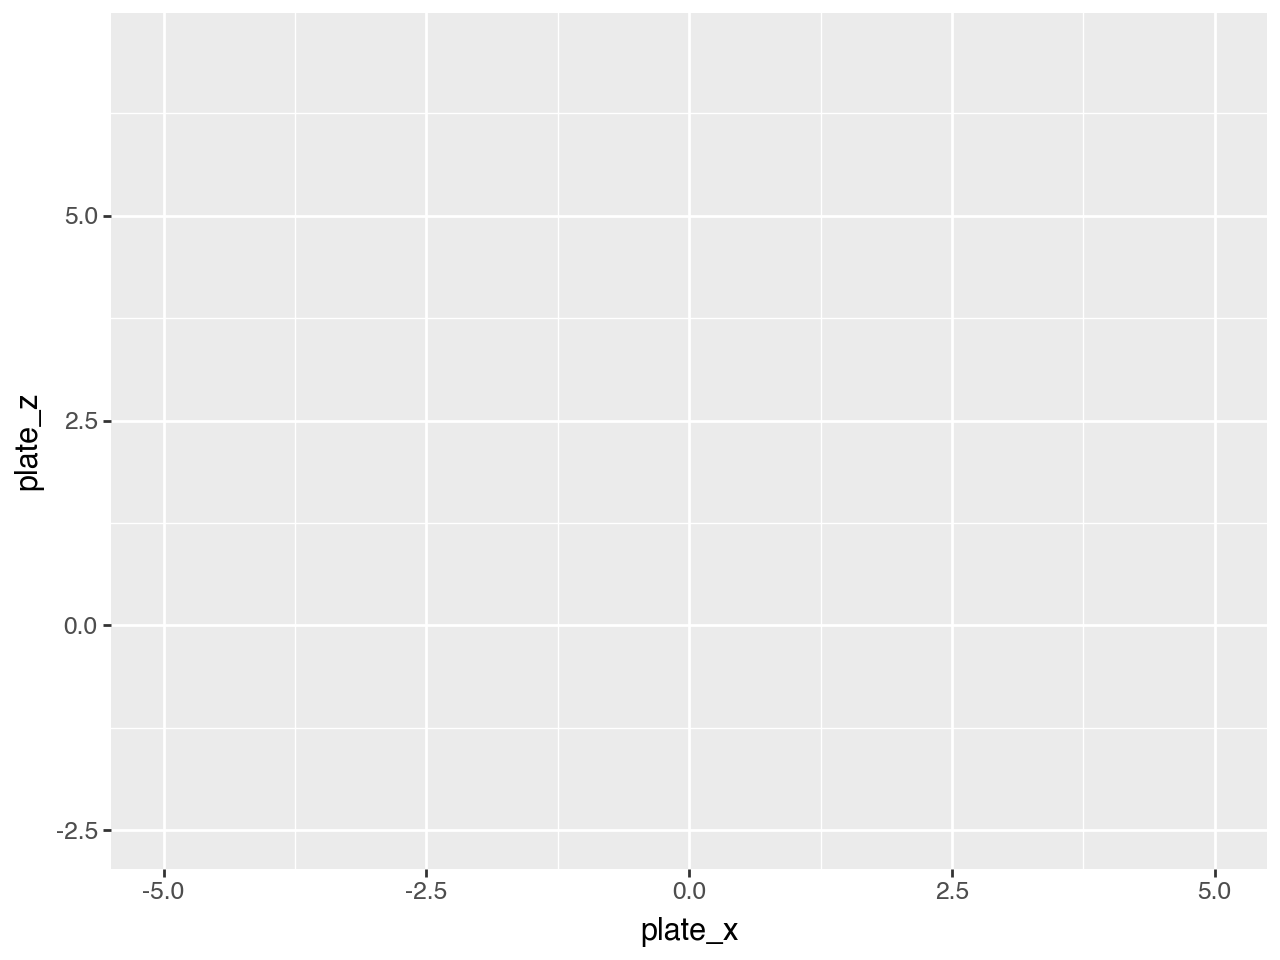

In [24]:
from plotnine import *

strike_zone = (
    geom_rect(
        ymax = 3.5, ymin = 1.5, 
        xmax = -1, xmin = 1, 
        alpha = 0, size=1,
        colour = 'black'
    )
)

pitch_zone_plot = (
    ggplot(df, aes(x='plate_x', y='plate_z'))
    + coord_cartesian(
        xlim = [-5, 5],
        ylim = [-2.5, 7]
    )
)
pitch_zone_plot

A visualization showing pitches to Ohtani. Each pitch is colored by pitch outcome.

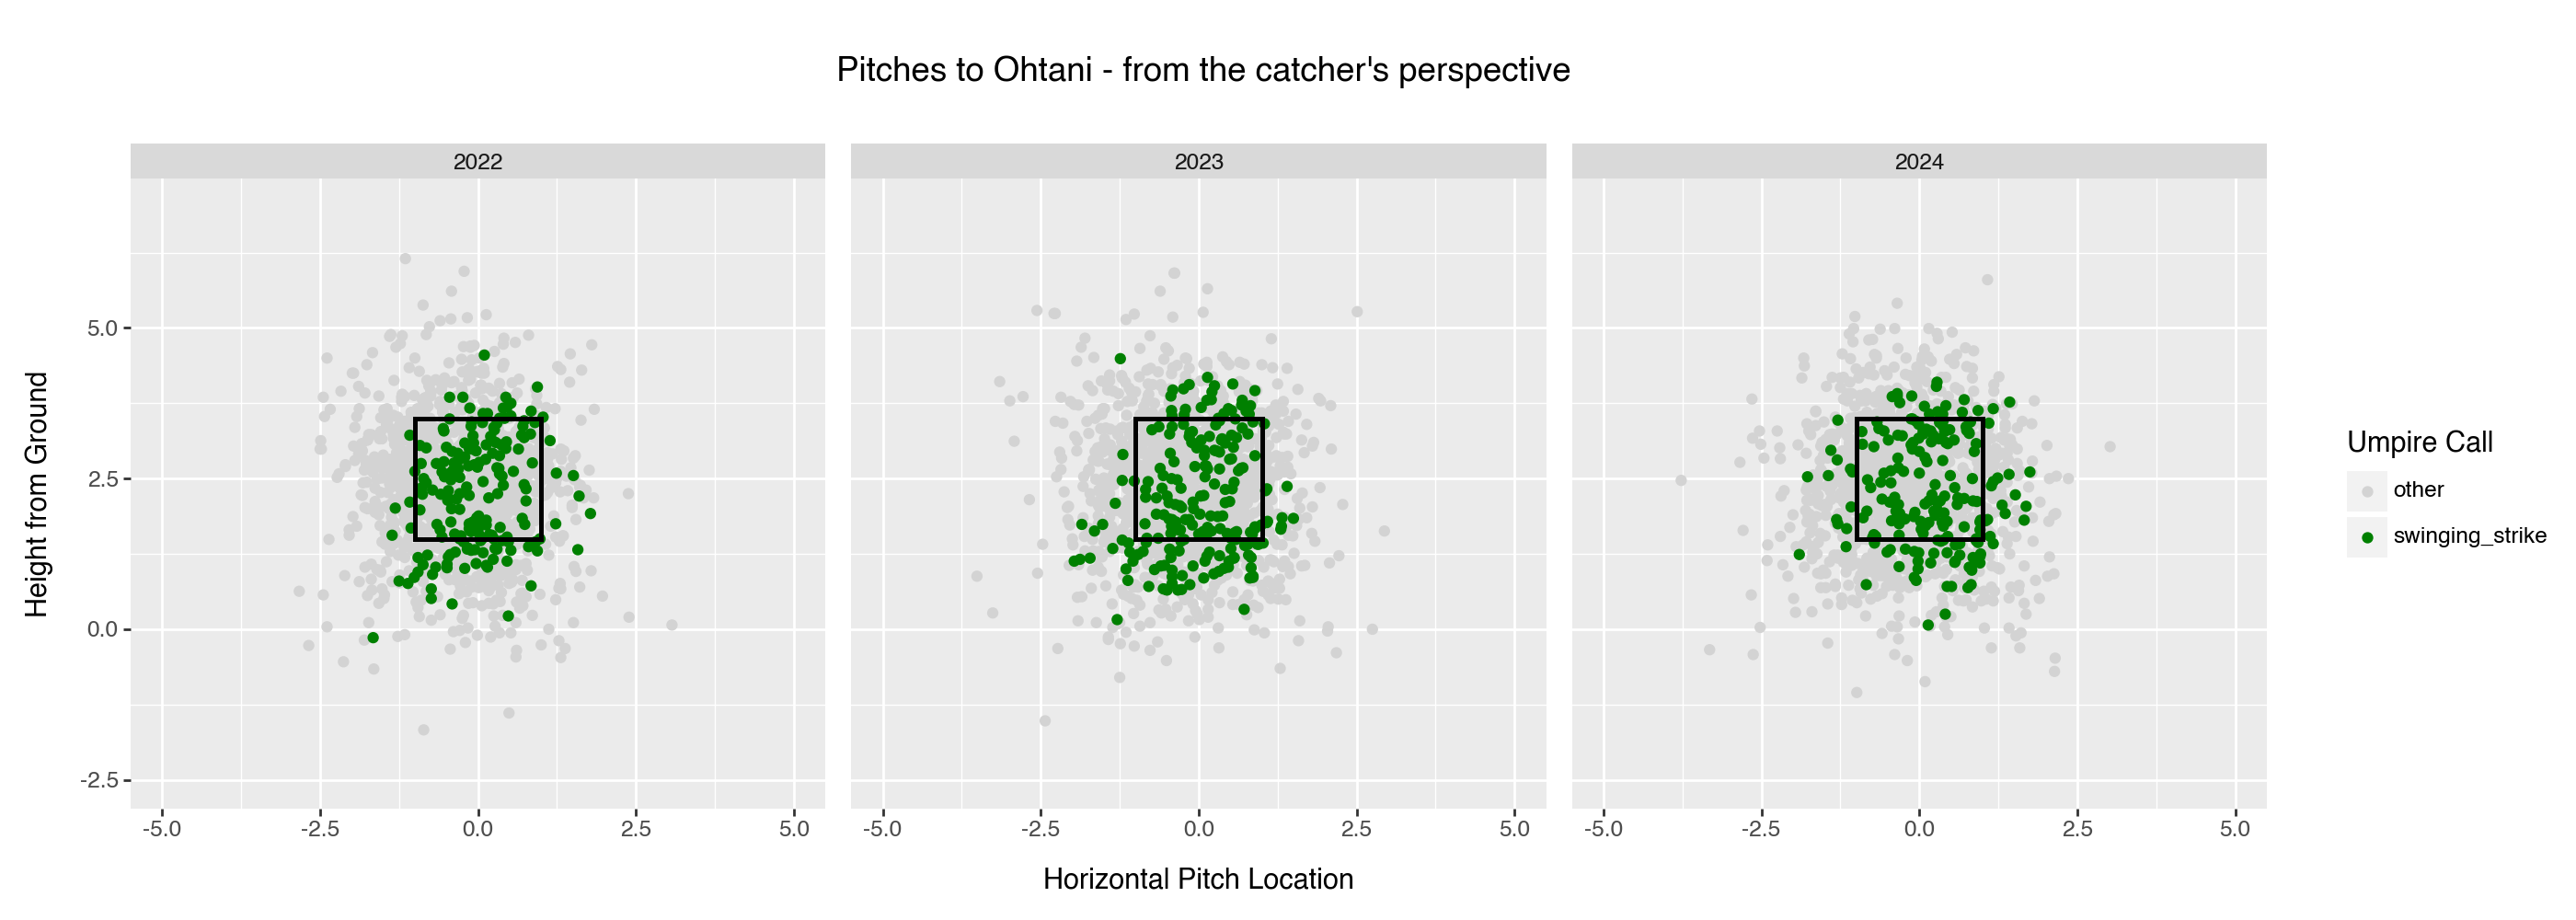

In [25]:
(
    pitch_zone_plot
    + geom_point(aes(color='swinging_strike_flg'))
    + strike_zone
    + facet_wrap('game_year')
    + scale_color_manual(values=['lightgray', 'green'])
    
    + labs(
        title='\n Pitches to Ohtani - from the catcher\'s perspective\n',
        x='Horizontal Pitch Location', 
        y='Height from Ground',
        color='Umpire Call'
    )
    + theme(figure_size=(14,5))
)

A visualization with more details on pitches. 

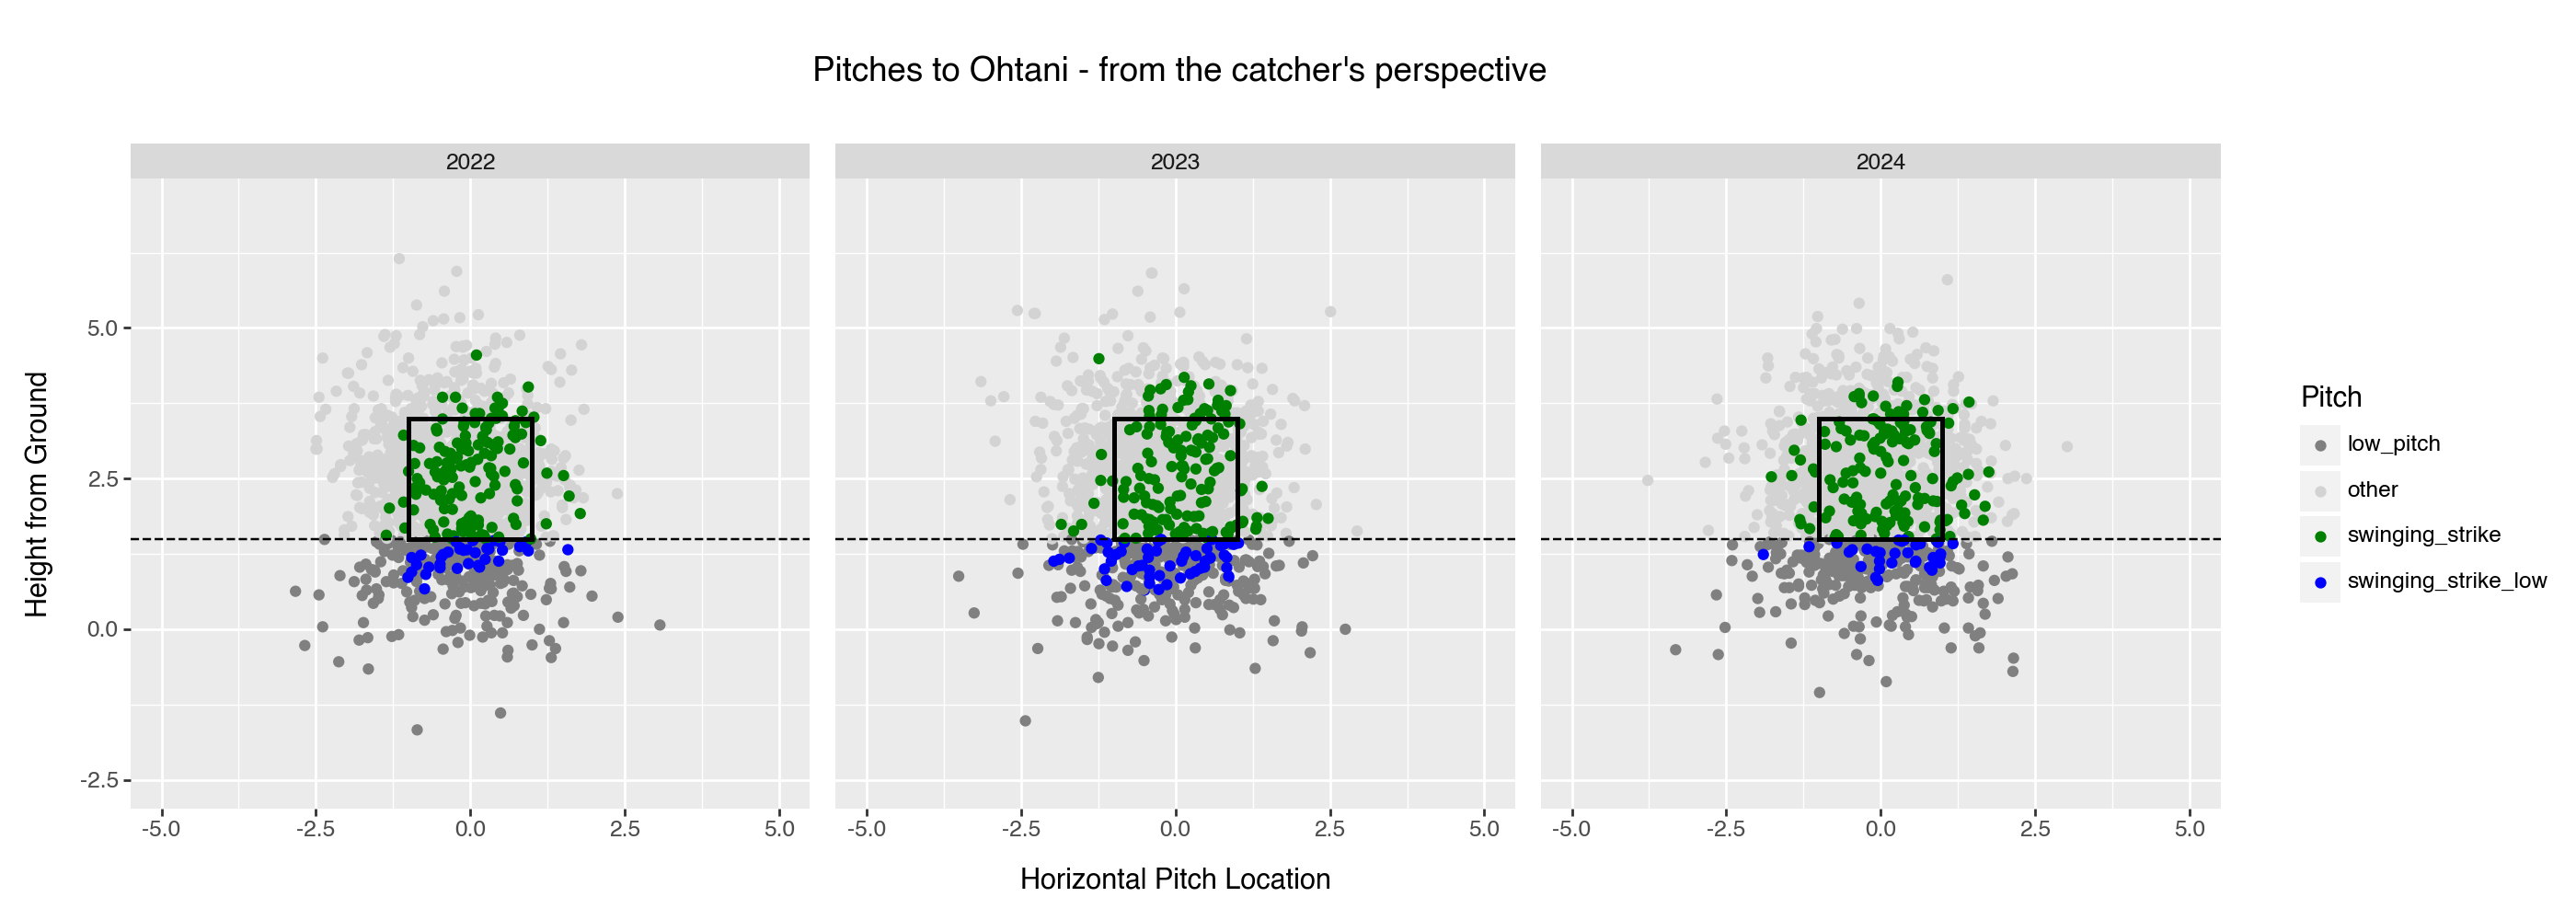

In [29]:
(
    pitch_zone_plot
    + geom_point(aes(color='swinging_strike_detail_flg'))
    + strike_zone
    + facet_wrap('game_year')
    + scale_color_manual(values=['gray', 'lightgray', 'green', 'blue'])
    + geom_hline(yintercept=lower_limit_strike_zone, linetype='dashed')
    + labs(
        title='\n Pitches to Ohtani - from the catcher\'s perspective\n',
        x='Horizontal Pitch Location', 
        y='Height from Ground',
        color='Pitch'
    )
    + theme(figure_size=(14,5))
)

Visualizing the swinging rate in a table visualization

In [19]:
(
    df
    .group_by(
        'game_year',
        'swinging_strike_detail_flg'
    )
    .len()
    .pivot(index='game_year',on='swinging_strike_detail_flg', values='len')
    .with_columns(
        pl.sum_horizontal(pl.all()).alias('total_pitches'),
        (
            ( (pl.col('swinging_strike_low') / pl.col('low_pitch')) * 100 ).round(1)
            .cast(pl.Utf8) + '%'
        )
        .alias('swinging_strike_perc_on_low_pitches')
    )
    .with_columns(
        (
            ( (pl.col('low_pitch') / pl.col('total_pitches')) * 100 ).round(1)  
            .cast(pl.Utf8) + '%'
        )
        .alias('low_pitch_perc')
    )
    .sort('game_year')
)

game_year,low_pitch,swinging_strike_low,swinging_strike,other,total_pitches,swinging_strike_perc_on_low_pitches,low_pitch_perc
i64,u32,u32,u32,u32,i64,str,str
2022,275,36,141,1094,3568,"""13.1%""","""7.7%"""
2023,278,54,150,1075,3580,"""19.4%""","""7.8%"""
2024,275,33,149,1158,3639,"""12.0%""","""7.6%"""
